In [35]:
import pandas as pd
from pycaret.classification import *
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function

In [30]:
def get_feat_importance(input_df,top_n):
    X = input_df.drop(columns=["abusive_flag"])
    y = input_df["abusive_flag"]
    
    # Train RandomForest
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X, y)
    
    # Get feature importance
    feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
    df_feat_important = pd.DataFrame({"feature":feature_importance.index, "value": feature_importance.values})
    # Plot feature importance
    plt.figure(figsize=(10, 5))
    sns.barplot(x=feature_importance.index[:top_n], y=feature_importance.values[:top_n], palette="coolwarm")
    plt.xticks(rotation=45)
    plt.title("Top Feature Importances (Random Forest)")
    plt.show()

    return df_feat_important
    
def highlight_max(s):
    if s.name == "Feature":
        return ["" for _ in s]
    is_max = s.astype(float) == s.astype(float).max() 
    return ["background-color: lightyellow" if v else "" for v in is_max]
    
def get_highlight_table(input_df,df_feat_important):
    median_values = input_df.groupby("abusive_flag").median()
    # Rename index for clarity
    median_values.index = ["Non-Abusive Users", "Abusive Users"]
    # Compute median for all users
    median_all_users = df_to_tune.median().rename("All Users")
    # Combine into a single DataFrame
    summary_table = median_values.T 
    summary_table["All Users"] = median_all_users
    # Reset index to make 'Feature' a column
    summary_table.reset_index(inplace=True)
    summary_table.rename(columns={"index": "feature"}, inplace=True)
    # Reorder the summary table based on feature importance
    summary_table = summary_table.set_index("feature").loc[df_feat_important["feature"]].reset_index()
    summary_table.iloc[:, 1:] = summary_table.iloc[:, 1:].applymap(lambda x: f"{x:.2f}")
    # Apply styling
    styled_table = summary_table.style.apply(highlight_max, axis=1, subset=summary_table.columns[1:])
    return styled_table
    
def median_comparison(input_features,top_n, input_df):
    for i, feature in enumerate(input_features[:top_n]):
        ## init chart
        plt.figure(figsize=(12, 5))
        ax = sns.barplot(data=input_df, x='abusive_flag', y=feature, estimator=np.median, palette="viridis")
        
        ## calculate median values
        overall_median = input_df[feature].median()
        abusive_median = input_df[input_df['abusive_flag'] == 1][feature].median()
        non_abusive_median = input_df[input_df['abusive_flag'] == 0][feature].median()
        
        # Annotate bars with median values
        for p, value in zip(ax.patches, [non_abusive_median, abusive_median]):
            ax.annotate(f'{value:.3f}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')
    
        # Annotate the overall median line
        plt.text(1.15, overall_median, f'Overall Median: {overall_median:.2f}', 
                 color='red', fontsize=12, fontweight='bold')
        ## add overall median line and chart info
        plt.axhline(overall_median, color='red', linestyle='dashed', linewidth=2, label='Overall Median')
        plt.title(f"Median {feature} by Abusive Flag")
        plt.xlabel("Abusive Flag")
        plt.ylabel("Median Value")
        
        plt.show()

# Data Processing

### Read data

In [3]:
df_user = pd.read_csv("users.csv")
df_campaign = pd.read_csv("campaigns.csv")

### User Table

In [4]:
df_user.head()

,user_id,user_type,signed_up_at,ip_address,country_code,email_domain_type,email_domain,device_id,identity_score,number_of_imported_lists,median_list_data_fields,total_subscribers,abusive_flag
0,d829b3cb-1ab2-42cf-a25a-db316fbdbb55,trial,2024-01-01 02:58:06.830434,101.98.104.40,NZ,custom domain,custom15.com,nakvLm9kHqAQYlxKnnAr,NaN,NaN,NaN,NaN,False
1,cd2b275c-0dc4-48b9-b598-ba97d3ca21f9,trial,2024-01-01 04:07:03.650317,95.239.235.182,IT,public domain,libero.it,ASNd40RSpD8Njj9lxYsm,NaN,NaN,NaN,NaN,False
2,a9c4c644-86fe-45a3-a303-e3055c37c663,trial,2024-01-01 04:41:27.530027,93.86.151.139,RS,custom domain,custom22.com,d9lss1YSROn3lDNq2C55,NaN,1.0,2.0,3354.0,True
3,70365507-6df6-4f36-9b2a-d8b9bcebe558,trial,2024-01-01 05:58:35.591977,102.249.0.215,ZA,public domain,outlook.com,eU0JXKNOIJUNGPu1VpkX,NaN,NaN,NaN,NaN,False
4,e3ed95c2-70e6-4729-9629-a1329f53d012,trial,2024-01-01 06:31:48.843162,2a09:bac2:57a6:1e1::30:86,TN,public domain,gmail.com,GuIYnufeKi2GUDTpsgL1,NaN,NaN,NaN,NaN,True


- Cần remove các cột như ip_address, email_domain
- Đối với các numerical columns, cần xử lý null value nếu data chưa có. Do hiện tại chưa biết nguyên nhân vì sao null value nên tạm thời không có action gì với null

In [5]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256554 entries, 0 to 256553
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   user_id                   256554 non-null  object 
 1   user_type                 256554 non-null  object 
 2   signed_up_at              256554 non-null  object 
 3   ip_address                256554 non-null  object 
 4   country_code              256491 non-null  object 
 5   email_domain_type         256554 non-null  object 
 6   email_domain              256554 non-null  object 
 7   device_id                 139244 non-null  object 
 8   identity_score            106085 non-null  float64
 9   number_of_imported_lists  36068 non-null   float64
 10  median_list_data_fields   35740 non-null   float64
 11  total_subscribers         65262 non-null   float64
 12  abusive_flag              256554 non-null  bool   
dtypes: bool(1), float64(4), object(8)
memory usa

Phần lớn user không abusive. Nguyên nhân là do chưa có label hay thực sự là như thế?

In [6]:
## Num user by abusive_flag
df_user.groupby("abusive_flag")["user_id"].count()

abusive_flag
False    240109
True      16445
Name: user_id, dtype: int64

In [7]:

## check has_device
df_user["is_device_identified"] = df_user["device_id"].notnull().astype(int)

# Calculate active duration (days)
df_user["signed_up_at"] = pd.to_datetime(df_user["signed_up_at"])
df_user["days_active"] = (datetime.now() - df_user["signed_up_at"]).dt.days

# Columns to encode
categorical_columns = ["user_type", "email_domain_type"]  # Add more columns as needed
label_mappings = {}

# Initialize and apply LabelEncoder
for col in categorical_columns:
    le = LabelEncoder()
    df_user[col + "_encoded"] = le.fit_transform(df_user[col])
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Display encoded dataframe
df_user_cleaned = df_user[["user_id","is_device_identified","days_active","user_type_encoded","email_domain_type_encoded","identity_score","number_of_imported_lists","median_list_data_fields","total_subscribers","abusive_flag"]]
df_user_cleaned = df_user_cleaned.drop_duplicates()

In [8]:
df_user_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256554 entries, 0 to 256553
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   user_id                    256554 non-null  object 
 1   is_device_identified       256554 non-null  int32  
 2   days_active                256554 non-null  int64  
 3   user_type_encoded          256554 non-null  int32  
 4   email_domain_type_encoded  256554 non-null  int32  
 5   identity_score             106085 non-null  float64
 6   number_of_imported_lists   36068 non-null   float64
 7   median_list_data_fields    35740 non-null   float64
 8   total_subscribers          65262 non-null   float64
 9   abusive_flag               256554 non-null  bool   
dtypes: bool(1), float64(4), int32(3), int64(1), object(1)
memory usage: 14.9+ MB


In [9]:
df_user_cleaned.head()

,user_id,is_device_identified,days_active,user_type_encoded,email_domain_type_encoded,identity_score,number_of_imported_lists,median_list_data_fields,total_subscribers,abusive_flag
0,d829b3cb-1ab2-42cf-a25a-db316fbdbb55,1,453,1,0,NaN,NaN,NaN,NaN,False
1,cd2b275c-0dc4-48b9-b598-ba97d3ca21f9,1,453,1,1,NaN,NaN,NaN,NaN,False
2,a9c4c644-86fe-45a3-a303-e3055c37c663,1,453,1,0,NaN,1.0,2.0,3354.0,True
3,70365507-6df6-4f36-9b2a-d8b9bcebe558,1,453,1,1,NaN,NaN,NaN,NaN,False
4,e3ed95c2-70e6-4729-9629-a1329f53d012,1,453,1,1,NaN,NaN,NaN,NaN,True


### Campaign Table

In [10]:
df_campaign.head()

,user_id,campaign_id,send_time,email_sends,unique_opens,unique_clicks,unsubscribes,complaints
0,29c4f30d-7bae-4c81-9aae-6e08363693fb,65930ff3cb479f60d19d7082,2024-01-01 12:51:19,1136,846,1,2,0
1,d1a9251a-81df-4813-9d30-532d8c029693,659c2c6786d7a4319cdeca56,2024-01-08 09:29:52,5,5,5,0,0
2,d1a9251a-81df-4813-9d30-532d8c029693,65aeb97c8e015202008b2769,2024-01-22 11:13:42,5,5,4,0,0
3,d1a9251a-81df-4813-9d30-532d8c029693,65932435abe464e127fa528e,2024-01-01 13:12:15,6,6,6,0,0
4,d1a9251a-81df-4813-9d30-532d8c029693,659318469321556ed13b2f5e,2024-01-01 12:44:25,1,1,1,0,0


In [11]:
# Convert 'send_time' to datetime format
df_campaign["send_time"] = pd.to_datetime(df_campaign["send_time"])

# Create a new column 'daytime_flag' (1 = daytime, 0 = nighttime)
df_campaign["daytime_flag"] = df_campaign["send_time"].dt.hour.between(7, 17).astype(int)
df_campaign["unique_opens_cr"] = df_campaign["unique_opens"]/df_campaign["email_sends"]
df_campaign["unique_clicks_cr"] = df_campaign["unique_clicks"]/df_campaign["email_sends"]
df_campaign["unsubscribes_pct"] = df_campaign["unsubscribes"]/df_campaign["email_sends"]

# Group by 'user_id' and calculate required aggregations
df_campaign_cleaned = df_campaign.groupby("user_id").agg(
    num_campaign=("campaign_id", "count"),
    num_campaign_daytime=("daytime_flag", "sum"),
    avg_email_sends=("email_sends", "mean"),
    avg_open_mail_cr=("unique_opens_cr", "mean"),
    avg_ctr=("unique_clicks_cr", "mean"),
    avg_unsubscribes=("unsubscribes", "mean"),
    avg_complaints =("complaints", "mean"),
    avg_unsubscribes_pct=("unsubscribes_pct", "mean")
).reset_index()
df_campaign_cleaned["campaign_daytime_pct"] = df_campaign_cleaned["num_campaign_daytime"]/df_campaign_cleaned["num_campaign"]
df_campaign_cleaned.drop("num_campaign_daytime",axis = 1,inplace = True)
df_campaign_cleaned.head()

,user_id,num_campaign,avg_email_sends,avg_open_mail_cr,avg_ctr,avg_unsubscribes,avg_complaints,avg_unsubscribes_pct,campaign_daytime_pct
0,0000cc06-b3f0-4ea7-831b-ebf4a671291a,3,2742.333333,0.246556,0.038206,33.666667,4.333333,0.011791,0.666667
1,00024e6f-6ab2-48e9-b2a7-2a6936d1fa53,1,196.000000,0.984694,0.030612,1.000000,0.000000,0.005102,1.000000
2,00042bfd-2d89-46fe-a24b-905e88e4f20e,3,9954.000000,0.069970,0.008707,7.333333,1.666667,0.000706,0.666667
3,0007fb9c-2f12-4ecb-97a6-4e7f884f3c1a,1,3991.000000,0.737159,0.023052,247.000000,11.000000,0.061889,1.000000
4,000844bc-c0e0-4809-97be-3bd12a6f73a6,6,238.666667,0.225359,0.116286,0.333333,1.333333,0.000235,1.000000


### Merge 2 dataframe

In [12]:
df_final = df_user_cleaned.merge(df_campaign_cleaned, on='user_id', how='inner')
df_final["abusive_flag"] = df_final["abusive_flag"].astype(int)
target_var = "abusive_flag"
cat_var = ["is_device_identified","user_type_encoded","email_domain_type_encoded"]
df_to_tune = df_final[[col for col in df_final.columns if col not in ["user_id",target_var]] + [target_var]]

In [13]:
df_to_tune.count()

is_device_identified         44779
days_active                  44779
user_type_encoded            44779
email_domain_type_encoded    44779
identity_score               28630
number_of_imported_lists     27985
median_list_data_fields      27834
total_subscribers            44470
num_campaign                 44779
avg_email_sends              44779
avg_open_mail_cr             44779
avg_ctr                      44779
avg_unsubscribes             44779
avg_complaints               44779
avg_unsubscribes_pct         44779
campaign_daytime_pct         44779
abusive_flag                 44779
dtype: int64

In [14]:
df_to_tune.head()

,is_device_identified,days_active,user_type_encoded,email_domain_type_encoded,identity_score,number_of_imported_lists,median_list_data_fields,total_subscribers,num_campaign,avg_email_sends,avg_open_mail_cr,avg_ctr,avg_unsubscribes,avg_complaints,avg_unsubscribes_pct,campaign_daytime_pct,abusive_flag
0,1,453,1,1,NaN,NaN,NaN,2.0,1,2.0,1.000000,0.000000,0.0,0.0,0.000000,1.0,0
1,1,452,1,0,NaN,NaN,NaN,1.0,1,1.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,0
2,1,452,1,1,NaN,NaN,NaN,13.0,1,13.0,0.615385,0.000000,0.0,0.0,0.000000,0.0,0
3,1,452,1,0,NaN,1.0,25.0,391.0,1,391.0,0.708440,0.017903,1.0,0.0,0.002558,1.0,0
4,1,452,1,1,NaN,NaN,NaN,1.0,1,1.0,0.000000,0.000000,0.0,0.0,0.000000,1.0,0


# EDA to highlight abusive users' behaviour

## **Key Characteristics of Abusive Users (Based on Median Values)**

### 1. Higher Subscriber Base  
- Abusive users have a **median total_subscribers of 1999**, compared to only **124 for non-abusive users**.  
- This indicates that abusive users tend to have a significantly larger audience.

### 2. Lower Engagement with Emails  
- **avg_open_mail_cr (email open rate)** is only **0.22** for abusive users, while non-abusive users have a much higher rate of **0.79**.  
- **avg_ctr (click-through rate)** is **0.01** for abusive users, compared to **0.05** for non-abusive users.  
- These metrics suggest that emails sent by abusive users receive much less engagement.

### 3. Higher Email Sending Volume  
- Abusive users send significantly more emails, with a **median avg_email_sends of 991**, compared to only **46 for non-abusive users**.  
- This aligns with the pattern of bulk/mass emailing, which is often linked to abusive behavior.

### 4. Shorter Active Period  
- **days_active** for abusive users is **166**, whereas non-abusive users have a median of **286** days.  
- Abusive users tend to have a shorter account lifespan.

### 5. Lower Campaign Activity  
- **num_campaign** (number of campaigns) is **1.00** for abusive users, compared to **4.00** for non-abusive users.  
- This suggests that abusive users focus on fewer but larger-scale campaigns.

### 6. More Unsubscribes  
- **avg_unsubscribes** is **2.00** for abusive users, while non-abusive users only have **0.18**.  
- Higher unsubscribe rates indicate that recipients are more likely to opt out of communications from abusive users.

### 7. Fewer Data Fields in Lists  
- **median_list_data_fields** is only **1.00** for abusive users, compared to **8.00** for non-abusive users.  
- This implies that abusive users maintain lower-quality data, possibly for mass messaging purposes.

### 8. Lower Identity Score  
- The **identity_score** for abusive users is only **2.00**, whereas non-abusive users have a median score of **5.00**.  
- This suggests that abusive users may have weaker verification or credibility.

---

### **Summary**
Abusive users tend to send a **higher volume of emails** to a **large subscriber base**, but their engagement rates (open and click rates) are **very low**. They are **active for a shorter period**, have **higher unsubscribe rates**, and **fewer data fields in their lists**, which may indicate lower data quality or automated/bulk behavior.



## Chart Generation

### Get feature importance

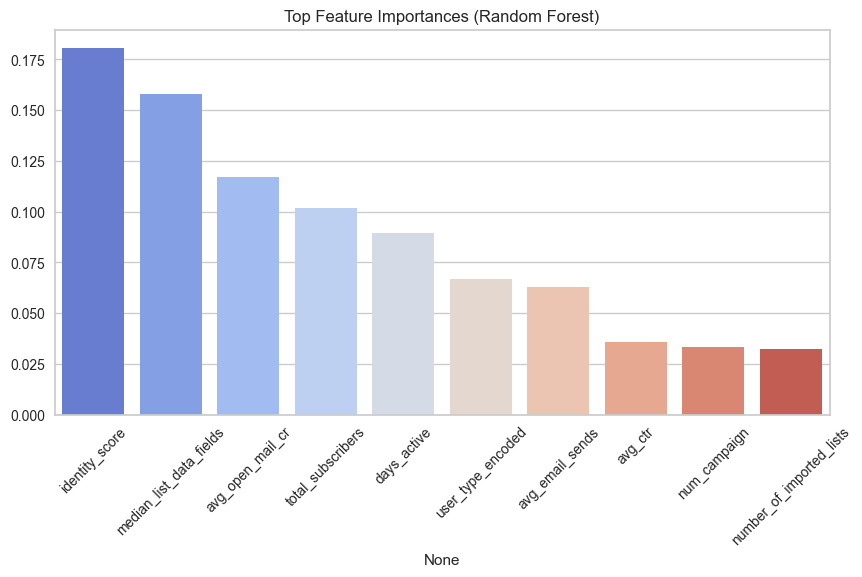

In [21]:
df_feat_important = get_feat_importance(input_df = df_to_tune, top_n = 10)

### Chart compare median values

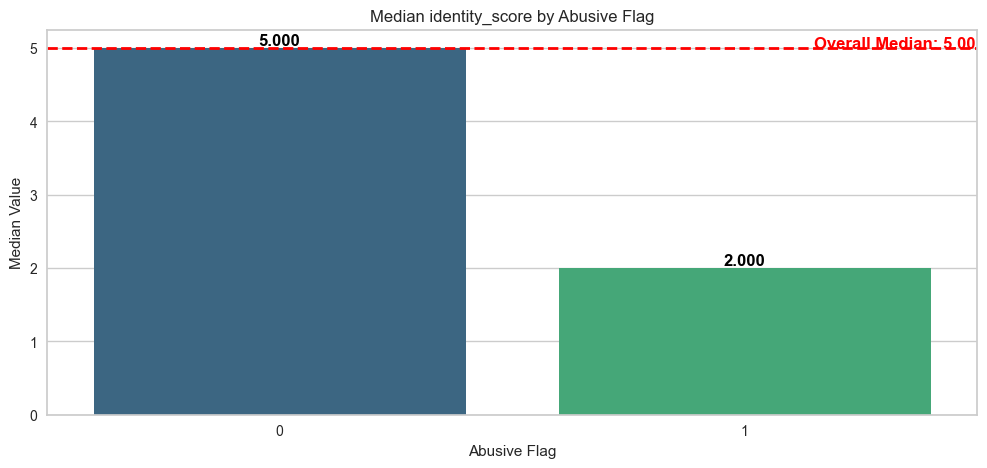

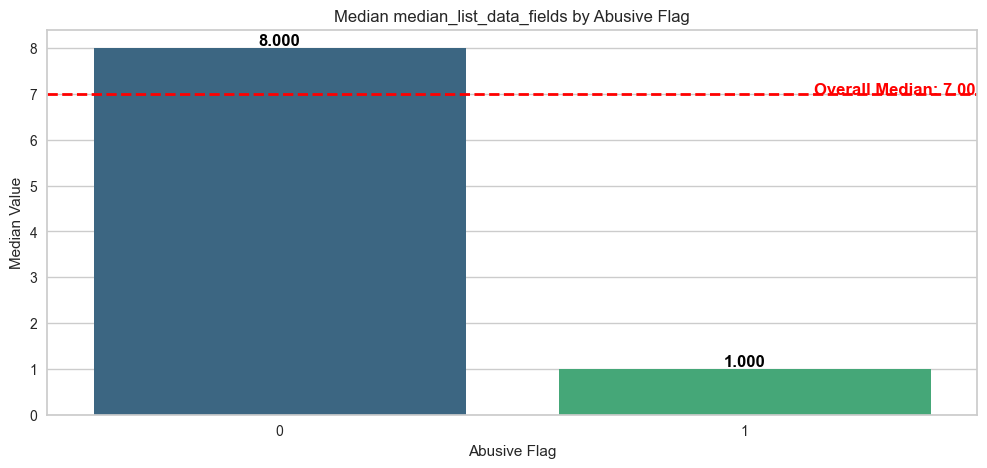

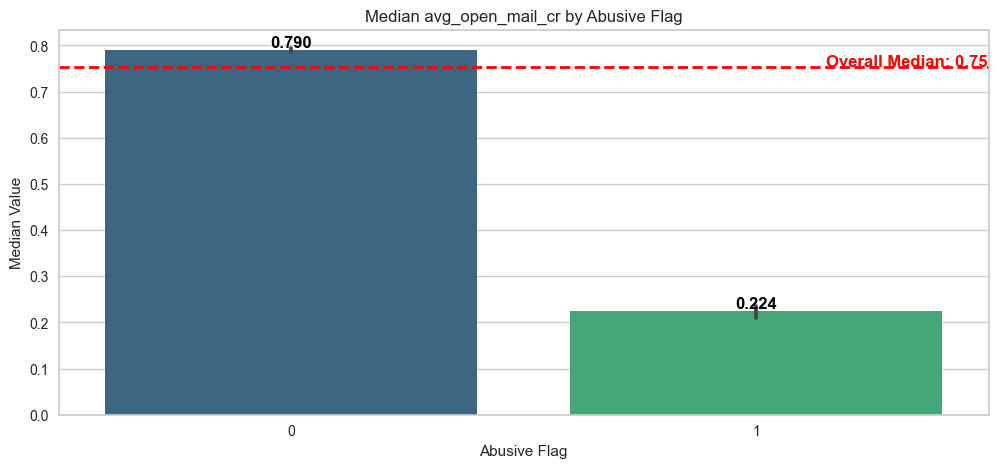

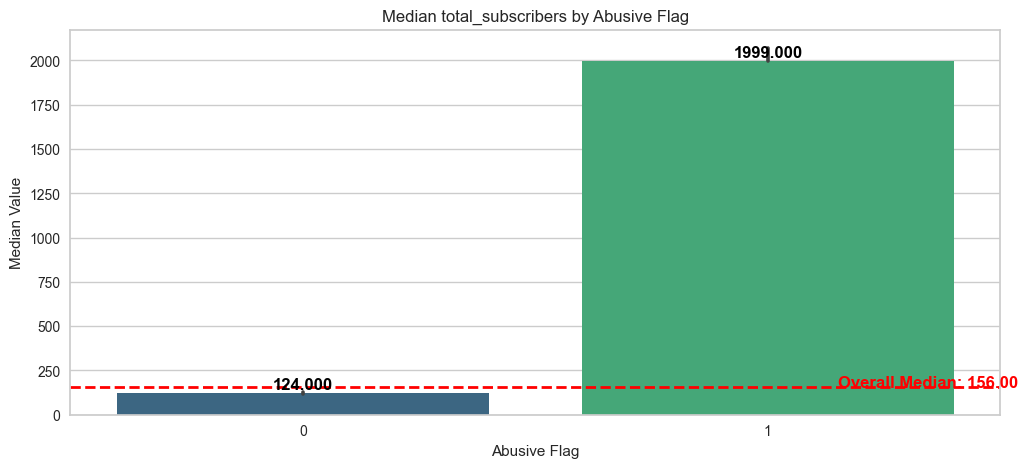

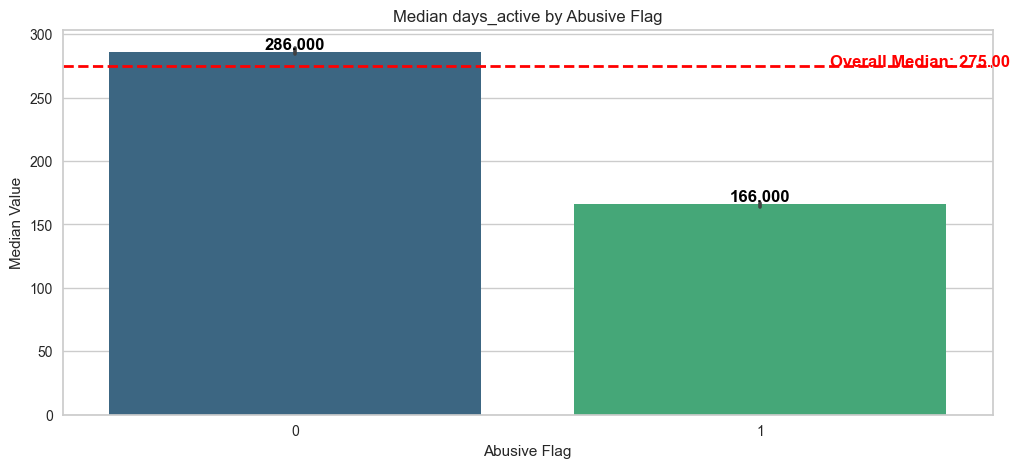

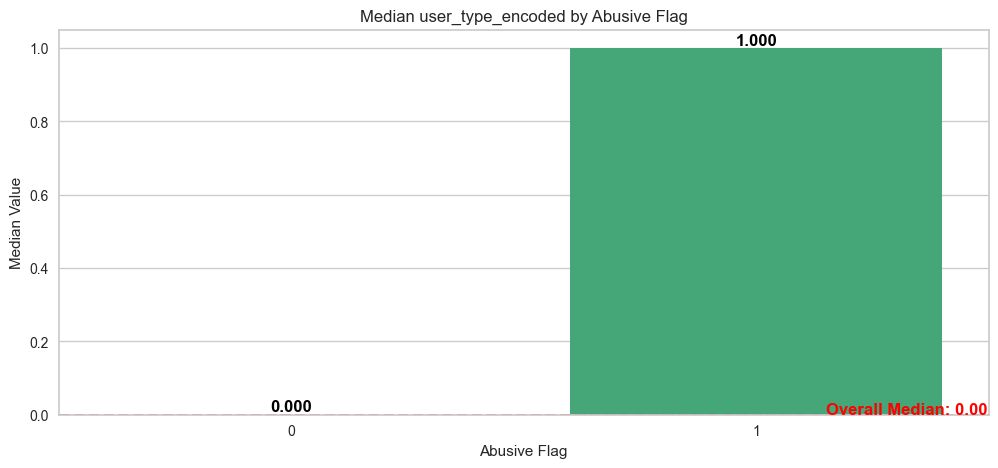

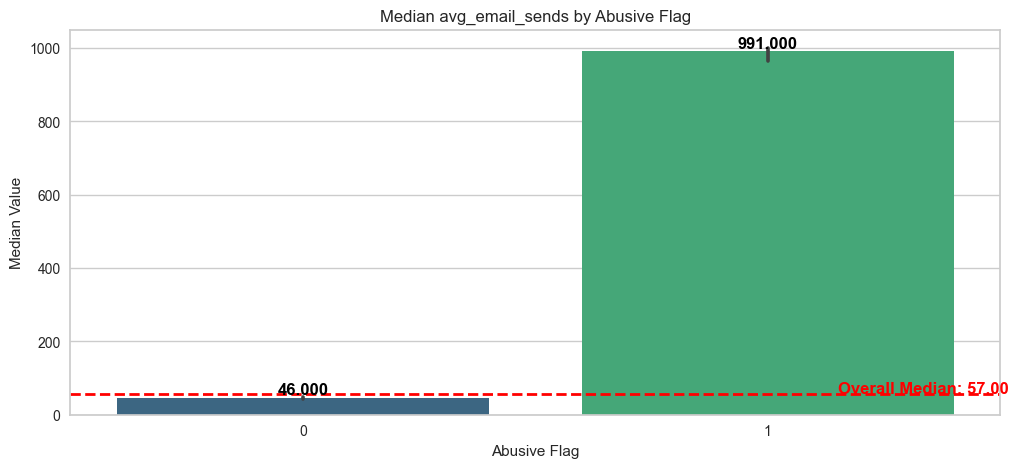

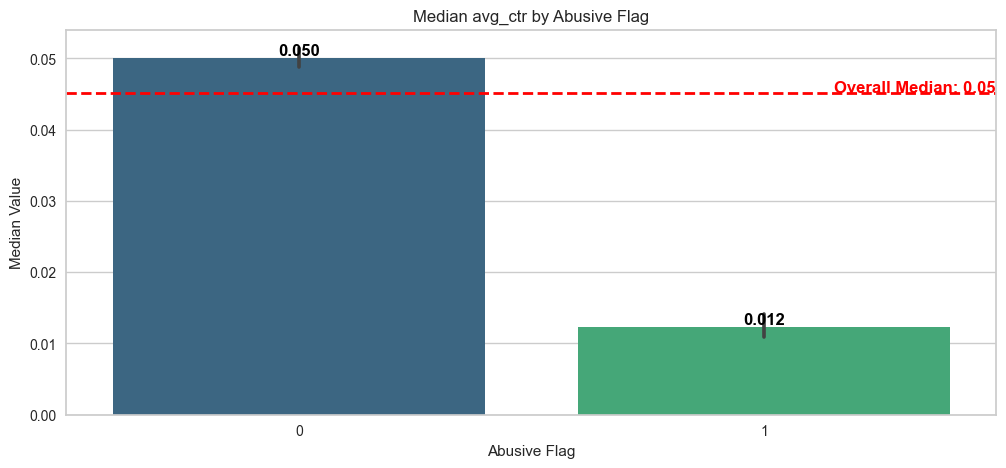

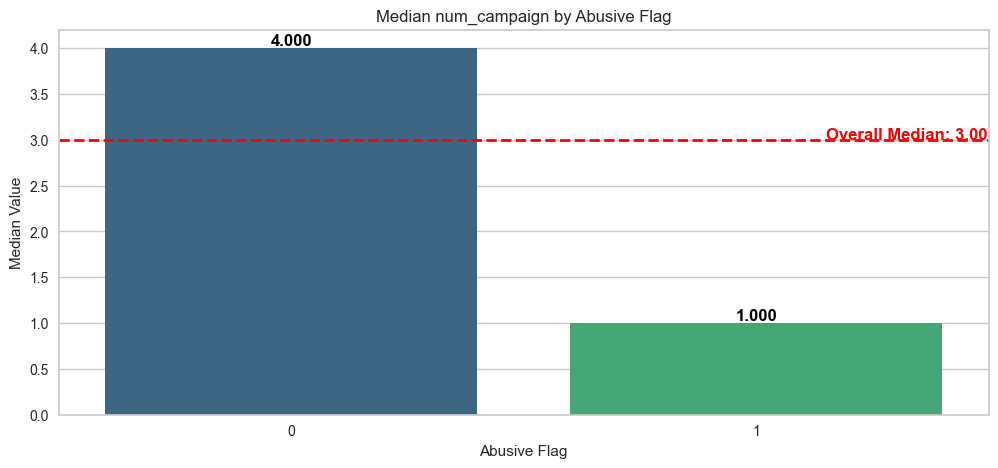

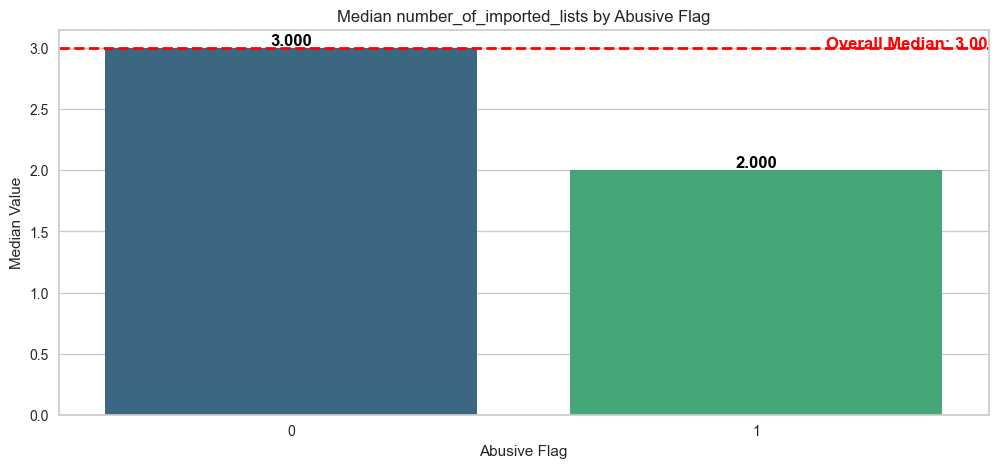

In [28]:
median_comparison(input_features = list(df_feat_important["feature"].unique()),top_n = 10, input_df = df_to_tune)

In [29]:
highlight_table = get_highlight_table(input_df = df_to_tune,df_feat_important = df_feat_important)
highlight_table

,feature,Non-Abusive Users,Abusive Users,All Users
0,identity_score,5.00,2.00,5.00
1,median_list_data_fields,8.00,1.00,7.00
2,avg_open_mail_cr,0.79,0.22,0.75
3,total_subscribers,124.00,1999.00,156.00
4,days_active,286.00,166.00,275.00
5,user_type_encoded,0.00,1.00,0.00
6,avg_email_sends,46.00,991.00,57.00
7,avg_ctr,0.05,0.01,0.05
8,num_campaign,4.00,1.00,3.00
9,number_of_imported_lists,3.00,2.00,3.00


**Need to improve**: Highlight the proportion of categorical values

# AutoML classification to find best model

## Model Result

### Classification Report Summary

#### 1. Overall Model Performance
- **Accuracy:** 97% (Correctly classifies 97 out of 100 users)

#### 2. Non-Abusive Users (Majority Class)
- **Precision:** 98% (98% of predicted non-abusive users were truly non-abusive)
- **Recall:** 98% (98% of actual non-abusive users were correctly identified)
- **F1-score:** 98% (Balanced trade-off between precision and recall)

#### 3. Abusive Users (Minority Class)
- **Precision:** 83% (83% of predicted abusive users were actually abusive)
- **Recall:** 80% (80% of actual abusive users were correctly classified)
- **F1-score:** 82% (Moderate balance between precision and recall)

#### 5. Confusion Matrix Insights
| Actual \ Predicted | Non-Abusive | Abusive |
|--------------------|------------|---------|
| **Non-Abusive**    | 8,022      | 128     |
| **Abusive**        | 161        | 645     |

- **False Positives:** 128 (Non-abusive users misclassified as abusive)
- **False Negatives:** 161 (Abusive users misclassified as non-abusive)

#### 6. Key Takeaways
- The model prioritizes **precision over recall**, meaning it aims to **minimize false positives** (incorrectly flagging non-abusive users as abusive).  
- **Precision for abusive users is 83%**, ensuring that most flagged abusive users are indeed abusive.  
- **Some abusive users (161) are missed**, but this is acceptable given the focus on **avoiding misclassifying legitimate users**.  
- This approach is ideal when **false accusations are more costly than missing some abusive users** (e.g., fraud detection where wrongly banning a good user is worse than missing a few bad ones).  
- **Further improvement:**  
  - Fine-tune the **decision threshold** to further improve precision.  
  - Use **cost-sensitive learning** to penalize false positives more heavily.  


### Finetune Model

In [ ]:
## train test split 
train_df, test_df = train_test_split(df_to_tune, test_size=0.2, random_state=42, stratify=df_to_tune["abusive_flag"])

## AutoML to select model with highest Precision
clf = setup(train_df, 
            target="abusive_flag", 
            session_id=42, 
            verbose=False, 
            fix_imbalance=True,
            categorical_features= cat_var)
# **Compare and Select Best Model**
best_model = compare_models(sort='Precision')
# **Hyperparameter Tuning**
tuned_model = tune_model(best_model)
# **Predict on Test Data**
predictions = predict_model(tuned_model, data=test_df, raw_score=True)

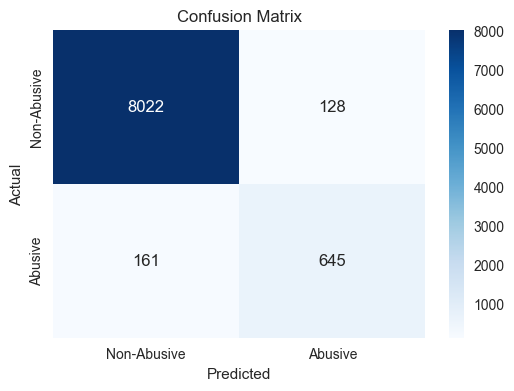


Classification Report:

              precision    recall  f1-score   support

 Non-Abusive       0.98      0.98      0.98      8150
     Abusive       0.83      0.80      0.82       806

    accuracy                           0.97      8956
   macro avg       0.91      0.89      0.90      8956
weighted avg       0.97      0.97      0.97      8956



In [46]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ["Non-Abusive", "Abusive"]
cm = confusion_matrix(test_df['abusive_flag'], predictions['prediction_label'])
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n")
print(classification_report(test_df['abusive_flag'], predictions['prediction_label'], target_names=labels))

## Note for model:

### 1. Model Application Scope  
The model is designed for users who have promoted at least one campaign.  

### 2. Improving the Model for New Users (Cold Start Problem)  
To enhance model performance for new users with limited historical data, consider:  

- **Training a separate model** for new users who lack sufficient engagement data.  
- **Focusing on static attributes** (e.g., identity score, registration details) instead of historical behavior.  
- **Transitioning users** to the main model as more data becomes available.  